In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
import matplotlib.pyplot as plt


In [ ]:
!pip install -q -U keras-tuner
from keras_tuner import RandomSearch

### Load MNIST Dataset

In [ ]:
# load the mnist dataset 
(x1_train, y1_train), (x1_test, y1_test) = keras.datasets.mnist.load_data()

n_train_samples = len(x1_train)
n_test_samples = len(x1_test)
img_height , img_width = x1_train[0].shape
n_classes = len(set(y1_train))

print(f'No. of samples  in train data  :{x1_train.shape[0]}')
print(f'No. of samples  in test data   :{x1_test.shape[0]}')
print(f'Size of an image:{x1_train[0].shape}')
print(f'No. of classes:{n_classes}')

# Preprocess the data 
x1_train = x1_train.reshape(n_train_samples, img_height*img_width).astype("float32") / 255
x1_test = x1_test.reshape(n_test_samples, img_height*img_width).astype("float32") / 255

y1_train = y1_train.astype("float32")
y1_test = y1_test.astype("float32")

#y1_train = np_utils.to_categorical(y1_train, n_classes)
#y1_test = np_utils.to_categorical(y1_test, n_classes)


# choose last 1000 samples for validation and remaining for training
x1_val = x1_train[-10000:]
y1_val = y1_train[-10000:]
x1_train = x1_train[:-10000]
y1_train = y1_train[:-10000]

No. of samples  in train data  :60000
No. of samples  in test data   :10000
Size of an image:(28, 28)
No. of classes:10


### Load CIFAR-10 Dataset

In [ ]:
# load the mnist dataset 
(x2_train, y2_train), (x2_test, y2_test) = keras.datasets.cifar10.load_data()
print(f'No. of samples  in train data  :{x2_train.shape[0]}')
print(f'No. of samples  in test data   :{x2_test.shape[0]}')
print(f'Size of an image:{x2_train[0].shape}')

n_train_samples = len(x2_train)
n_test_samples = len(x2_test)
img_height , img_width, n_channel = x2_train[0].shape


# Preprocess the data 
x2_train = x2_train.reshape(n_train_samples, img_height*img_width*n_channel).astype("float32") / 255
x2_test = x2_test.reshape(n_test_samples, img_height*img_width*n_channel).astype("float32") / 255


#y2_train = np_utils.to_categorical(y2_train,10)
#y2_test = np_utils.to_categorical(y2_test, 10)

y2_train = y2_train.astype("float32")
y2_test = y2_test.astype("float32")



# choose last 1000 samples for validation and remaining for training
x2_val = x2_train[-10000:]
y2_val = y2_train[-10000:]
x2_train = x2_train[:-10000]
y2_train = y2_train[:-10000]

No. of samples  in train data  :50000
No. of samples  in test data   :10000
Size of an image:(32, 32, 3)


### Utility Function

In [ ]:
# function for ploting loss and accuracy for validation and test dataset
def plot_graph(history):
  val_loss = history.history['val_loss']
  train_loss = history.history['loss']
  val_accuracy = history.history['val_accuracy']
  train_accuracy = history.history['accuracy']
  x = list(range(1,len(val_loss)+1))
  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15, 5))
  ax1.plot(x,val_accuracy,'r',label = "Validation Accuarcy")
  ax1.plot(x,train_accuracy,'b',label = "Train Accuracy")
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuarcy')
  ax1.legend()
  ax1.grid()

  ax2.plot(x,val_loss,'r',label = "Validation loss")
  ax2.plot(x,train_loss,'b',label = "Train loss")
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Categorical Cross Entropy')
  ax2.legend()
  ax2.grid()
  plt.show()

### **Task-1:**
Create a base FNN model by choosing hyperparameters like number of layers, number of neurons in each layer, batch size, learning rate etc. Proper justification should be provided for hyperparameter selection.

Hyper parameteter tuning:
Used keras tuner which randomly try some combination of parameters and return best parameter based on validation accuaracy. For both mnist and cifar-10 classifier parameter choosed for parameter tuning are 
1. no.of hidden layers
2. No. of nodes in each hidden layer
3. Learning rate 

Choose batch size based on the number of samples in the training set

### MNITS Classifier

In [ ]:
# function for hyperparameter tuning with keras-tuner
def model_builder_mnist(hp):
  # various hyperparameters
  hp_units = hp.Int('units', min_value=10, max_value=100, step=10)
  hp_layers = hp.Int('layers', min_value=2, max_value=6)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  # model defined as sequential model
  model = keras.Sequential()
  model.add(keras.Input(shape=(28*28,)))                                # input layer
  for i in range(1, hp_layers):                                         # hidden layers
    model.add(layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))                                     #output layer
  
  # compile the model with adam optimizer 
  # output function as sigmoid
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model


In [ ]:
# hyperparameter tuning
# try 10 trials from the available combinations
tuner = RandomSearch(
    model_builder_mnist,
    objective='val_accuracy',
    max_trials= 10,
    executions_per_trial =2,
    overwrite=True
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x1_train,y1_train, epochs=5, validation_data=(x1_test,y1_test), callbacks=[stop_early])

Trial 10 Complete [00h 01m 15s]
val_accuracy: 0.9153500199317932

Best val_accuracy So Far: 0.9733499884605408
Total elapsed time: 00h 13m 22s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyper Parameters:\n----------------------")
print(f"No. of layers              :{best_hps.get('layers')}") 
print(f"No. of nodes in each layer :{best_hps.get('units')}")      
print(f"Learning rate              :{best_hps.get('learning_rate')}")   

Best hyper Parameters:
----------------------
No. of layers              :4
No. of nodes in each layer :90
Learning rate              :0.001


In [ ]:
# retrive best model
model11 = tuner.hypermodel.build(best_hps)
model11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 90)                70650     
                                                                 
 dense_3 (Dense)             (None, 90)                8190      
                                                                 
 dense_4 (Dense)             (None, 90)                8190      
                                                                 
 dense_5 (Dense)             (None, 10)                910       
                                                                 
Total params: 87,940
Trainable params: 87,940
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the best model for 20 epochs
# batch size is coosed as 64 based on the number of training samples
history = model11.fit(x1_train,
                    y1_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(x1_val, y1_val)
                    )

Epoch 1/20
782/782 [==============================] - 4s 4ms/step - loss: 0.3245 - accuracy: 0.9049 - val_loss: 0.1464 - val_accuracy: 0.9575
Epoch 2/20
782/782 [==============================] - 3s 4ms/step - loss: 0.1313 - accuracy: 0.9605 - val_loss: 0.1188 - val_accuracy: 0.9652
Epoch 3/20
782/782 [==============================] - 3s 4ms/step - loss: 0.0926 - accuracy: 0.9715 - val_loss: 0.1010 - val_accuracy: 0.9698
Epoch 4/20
782/782 [==============================] - 3s 4ms/step - loss: 0.0718 - accuracy: 0.9771 - val_loss: 0.0972 - val_accuracy: 0.9718
Epoch 5/20
782/782 [==============================] - 3s 4ms/step - loss: 0.0581 - accuracy: 0.9815 - val_loss: 0.0888 - val_accuracy: 0.9746
Epoch 6/20
782/782 [==============================] - 3s 4ms/step - loss: 0.0463 - accuracy: 0.9852 - val_loss: 0.0889 - val_accuracy: 0.9741
Epoch 7/20
782/782 [==============================] - 3s 4ms/step - loss: 0.0409 - accuracy: 0.9861 - val_loss: 0.0872 - val_accuracy: 0.9758
Epoch 

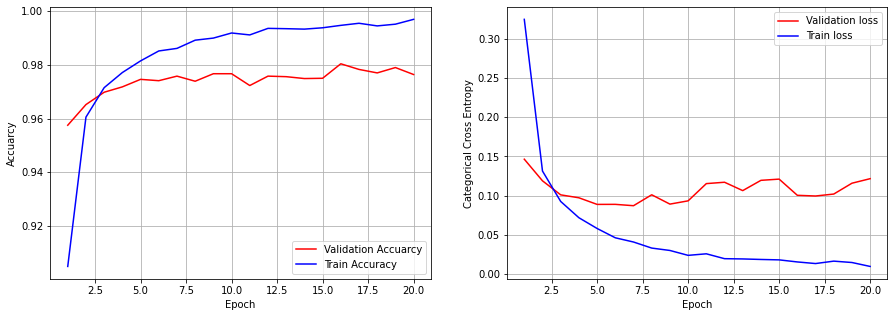

In [ ]:
# plot loss and accuracy curves
plot_graph(history)

Observations:
1. In each epochs training loss decreasing and valdation loss oscilating after 8 epochs 

### CIFAR-10 Classifier

In [ ]:
# function for hyperparameter tuning with keras-tuner
def model_builder_cifar(hp):
  # hyper parameters
  hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
  hp_layers = hp.Int('layers', min_value=2, max_value=6)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # define model
  model = keras.Sequential()
  model.add(keras.Input(shape=(32*32*3,)))
  for i in range(1, hp_layers):
    model.add(layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))
  
  # compile the model
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
# hyperparameter tuning 
# try 10 combinations of parametrs from the available combinations
tuner = RandomSearch(
    model_builder_cifar,
    objective='val_accuracy',
    max_trials= 10,
    executions_per_trial =2,
    overwrite=True
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x2_train,y2_train, epochs=5, validation_data=(x2_test,y2_test), callbacks=[stop_early])

Trial 10 Complete [00h 00m 57s]
val_accuracy: 0.4232500046491623

Best val_accuracy So Far: 0.46539999544620514
Total elapsed time: 00h 11m 37s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# best hyperparametrs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyper Parameters:\n----------------------")
print(f"No. of layers              :{best_hps.get('layers')}") 
print(f"No. of nodes in each layer :{best_hps.get('units')}")      
print(f"Learning rate              :{best_hps.get('learning_rate')}")  

Best hyper Parameters:
----------------------
No. of layers              :5
No. of nodes in each layer :256
Learning rate              :0.0001


In [ ]:
# retrieve best model
model12 = tuner.hypermodel.build(best_hps)
model12.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               786688    
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                                 
Total params: 986,634
Trainable params: 986,634
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit best model for 20  epochs
# batch size is coosed as 64 based on the number of training samples
history = model12.fit(x2_train,
                    y2_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(x2_val, y2_val)
                    )

Epoch 1/20
625/625 [==============================] - 4s 6ms/step - loss: 1.8757 - accuracy: 0.3232 - val_loss: 1.7482 - val_accuracy: 0.3722
Epoch 2/20
625/625 [==============================] - 3s 5ms/step - loss: 1.6696 - accuracy: 0.4031 - val_loss: 1.6454 - val_accuracy: 0.4159
Epoch 3/20
625/625 [==============================] - 3s 5ms/step - loss: 1.5861 - accuracy: 0.4341 - val_loss: 1.5962 - val_accuracy: 0.4308
Epoch 4/20
625/625 [==============================] - 3s 5ms/step - loss: 1.5309 - accuracy: 0.4537 - val_loss: 1.5711 - val_accuracy: 0.4388
Epoch 5/20
625/625 [==============================] - 3s 5ms/step - loss: 1.4826 - accuracy: 0.4713 - val_loss: 1.5390 - val_accuracy: 0.4530
Epoch 6/20
625/625 [==============================] - 3s 5ms/step - loss: 1.4450 - accuracy: 0.4848 - val_loss: 1.5060 - val_accuracy: 0.4711
Epoch 7/20
625/625 [==============================] - 3s 5ms/step - loss: 1.4186 - accuracy: 0.4953 - val_loss: 1.4875 - val_accuracy: 0.4765
Epoch 

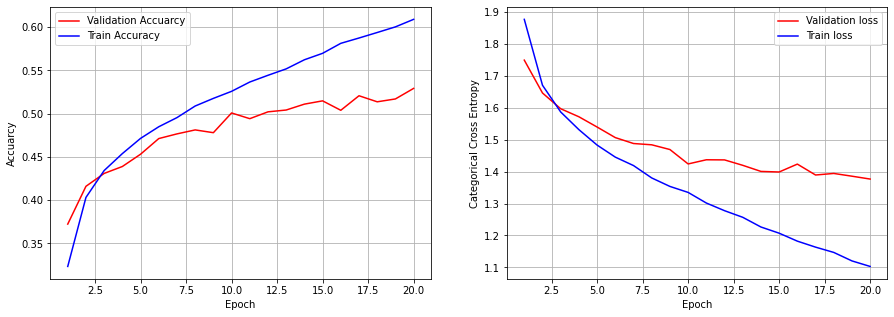

In [ ]:
# plot loss and accuracy curves
plot_graph(history)

Observations:
1. Both training loss and validation loss decreasing with each epoch. No overfit

### **Task-2**
Modify the base model created in task-1 by adding batch normalization layers after each layer.

In [ ]:
# function for defining and compiling model with batch normalisation
def my_model(input_size, n_classes, hidden_layers, n_nodes, learning_rate):
  model = keras.Sequential()
  model.add(keras.Input(shape=(input_size,)))
  for i in range(hidden_layers):
    model.add(layers.Dense(units=n_nodes, activation='relu'))
    model.add(layers.BatchNormalization())
  model.add(keras.layers.Dense(n_classes))
  print(model.summary())

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

### MNIST Classifier

In [ ]:
# define a model with 3 hidden layers (total layer=4) with 90 nodes in each (parameters got from task-1)
# output layer with 10 nodes
model21 = my_model(input_size =28*28,  n_classes =10, hidden_layers=3, n_nodes =90, learning_rate=0.001)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 90)                70650     
                                                                 
 batch_normalization (BatchN  (None, 90)               360       
 ormalization)                                                   
                                                                 
 dense_11 (Dense)            (None, 90)                8190      
                                                                 
 batch_normalization_1 (Batc  (None, 90)               360       
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 90)                8190      
                                                                 
 batch_normalization_2 (Batc  (None, 90)              

In [ ]:
history = model21.fit(x1_train,
                    y1_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(x1_val, y1_val)
                    )

Epoch 1/20
782/782 [==============================] - 7s 7ms/step - loss: 0.2899 - accuracy: 0.9122 - val_loss: 0.1289 - val_accuracy: 0.9634
Epoch 2/20
782/782 [==============================] - 5s 6ms/step - loss: 0.1258 - accuracy: 0.9614 - val_loss: 0.1040 - val_accuracy: 0.9686
Epoch 3/20
782/782 [==============================] - 5s 6ms/step - loss: 0.0915 - accuracy: 0.9706 - val_loss: 0.1037 - val_accuracy: 0.9682
Epoch 4/20
782/782 [==============================] - 5s 6ms/step - loss: 0.0745 - accuracy: 0.9757 - val_loss: 0.1091 - val_accuracy: 0.9685
Epoch 5/20
782/782 [==============================] - 5s 6ms/step - loss: 0.0624 - accuracy: 0.9798 - val_loss: 0.0923 - val_accuracy: 0.9721
Epoch 6/20
782/782 [==============================] - 5s 6ms/step - loss: 0.0529 - accuracy: 0.9832 - val_loss: 0.0832 - val_accuracy: 0.9759
Epoch 7/20
782/782 [==============================] - 5s 6ms/step - loss: 0.0471 - accuracy: 0.9850 - val_loss: 0.0882 - val_accuracy: 0.9738
Epoch 

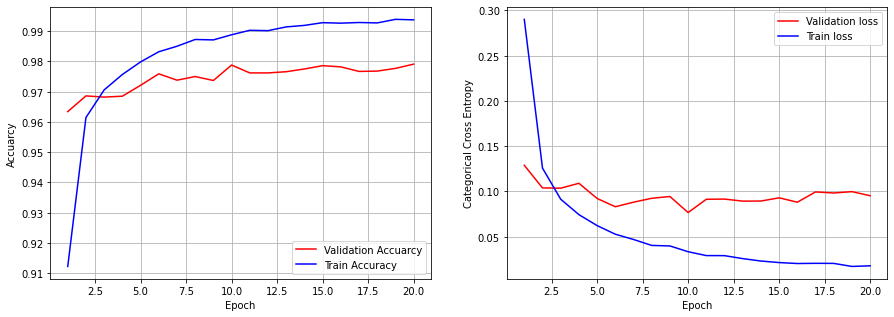

In [ ]:
plot_graph(history)

Observations:

1. No much improvement in validation accuracy 
2. Validation loss slightly decreased

So, model with batchnormalization layer gives better performance

### CIFAR-10 Classifier

In [ ]:
# define a model with 4 hidden layers(total layers = 5) with 256 nodes in each (parameters got from task-1)
# output layer with 10 nodes
model22 = my_model(input_size = 32*32*3,  n_classes = 10, hidden_layers=4, n_nodes =256, learning_rate=0.0001)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 256)               786688    
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_5 (Batc  (None, 256)             

In [ ]:
history = model22.fit(x2_train,
                    y2_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(x2_val, y2_val),
                    )

Epoch 1/20
625/625 [==============================] - 6s 8ms/step - loss: 1.9081 - accuracy: 0.3442 - val_loss: 1.9809 - val_accuracy: 0.3288
Epoch 2/20
625/625 [==============================] - 4s 7ms/step - loss: 1.5956 - accuracy: 0.4360 - val_loss: 1.7427 - val_accuracy: 0.3955
Epoch 3/20
625/625 [==============================] - 5s 7ms/step - loss: 1.4867 - accuracy: 0.4760 - val_loss: 1.8978 - val_accuracy: 0.3615
Epoch 4/20
625/625 [==============================] - 4s 7ms/step - loss: 1.4068 - accuracy: 0.5042 - val_loss: 1.6618 - val_accuracy: 0.4207
Epoch 5/20
625/625 [==============================] - 5s 7ms/step - loss: 1.3398 - accuracy: 0.5256 - val_loss: 1.5790 - val_accuracy: 0.4482
Epoch 6/20
625/625 [==============================] - 4s 7ms/step - loss: 1.2768 - accuracy: 0.5513 - val_loss: 1.6937 - val_accuracy: 0.4348
Epoch 7/20
625/625 [==============================] - 4s 7ms/step - loss: 1.2256 - accuracy: 0.5701 - val_loss: 1.6316 - val_accuracy: 0.4474
Epoch 

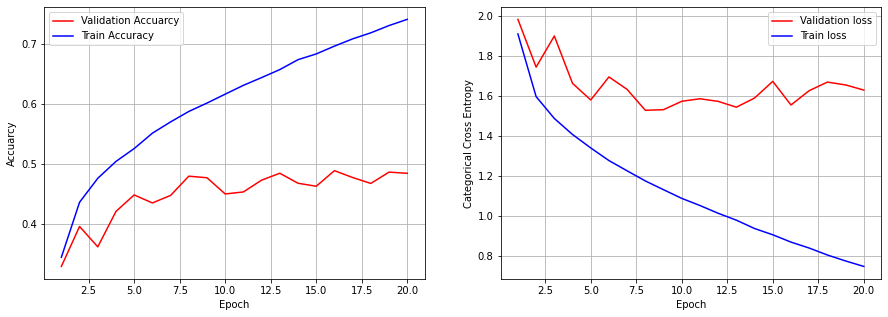

In [ ]:
plot_graph(history)

Observations:

1. A large gap between accuracies of taining and validation.
2. A large gap between losses of taining and validation. Overfit the model.
3. As compared with base model accuracy reduced and loss increased for validation

So model without batchnormalization layer gives better performance

### **Task-3**
Add dropout regularization (add a drop-out layer) to the model obtained in 
step 5. Train it and observe the changes in performance by plotting the 
accuracy and loss curves. 

In [ ]:
# defining the model with a dropout layer before output layer 
# option to select batch normalization layer after each hidden layer 

def regularized_model(input_size, n_classes, hidden_layers, n_nodes, learning_rate, normalization=False):
  model = keras.Sequential()
  model.add(keras.Input(shape=(input_size,)))
  for i in range(hidden_layers):
    model.add(layers.Dense(units=n_nodes, activation='relu'))
    if normalization==True:
      model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(keras.layers.Dense(n_classes))
  print(model.summary())

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

### MNIST Classifier

In [ ]:
# model with batch normalization gives a better accuarcy value compared to model in task 1
# built a model with batch normalisation and dropout layer

model31 = regularized_model(input_size = 28*28, n_classes=10, hidden_layers=3, n_nodes=90, learning_rate=0.001, normalization=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 90)                70650     
                                                                 
 batch_normalization_7 (Batc  (None, 90)               360       
 hNormalization)                                                 
                                                                 
 dense_20 (Dense)            (None, 90)                8190      
                                                                 
 batch_normalization_8 (Batc  (None, 90)               360       
 hNormalization)                                                 
                                                                 
 dense_21 (Dense)            (None, 90)                8190      
                                                                 
 batch_normalization_9 (Batc  (None, 90)              

In [ ]:
# train the model
history = model31.fit(x1_train,
                    y1_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(x1_val, y1_val)
                    )

Epoch 1/20
782/782 [==============================] - 6s 7ms/step - loss: 0.3319 - accuracy: 0.8985 - val_loss: 0.1430 - val_accuracy: 0.9573
Epoch 2/20
782/782 [==============================] - 5s 7ms/step - loss: 0.1490 - accuracy: 0.9543 - val_loss: 0.1070 - val_accuracy: 0.9677
Epoch 3/20
782/782 [==============================] - 6s 8ms/step - loss: 0.1100 - accuracy: 0.9658 - val_loss: 0.1009 - val_accuracy: 0.9705
Epoch 4/20
782/782 [==============================] - 5s 6ms/step - loss: 0.0900 - accuracy: 0.9714 - val_loss: 0.1005 - val_accuracy: 0.9717
Epoch 5/20
782/782 [==============================] - 5s 6ms/step - loss: 0.0742 - accuracy: 0.9763 - val_loss: 0.0818 - val_accuracy: 0.9762
Epoch 6/20
782/782 [==============================] - 5s 6ms/step - loss: 0.0678 - accuracy: 0.9785 - val_loss: 0.0886 - val_accuracy: 0.9749
Epoch 7/20
782/782 [==============================] - 5s 7ms/step - loss: 0.0573 - accuracy: 0.9818 - val_loss: 0.0935 - val_accuracy: 0.9742
Epoch 

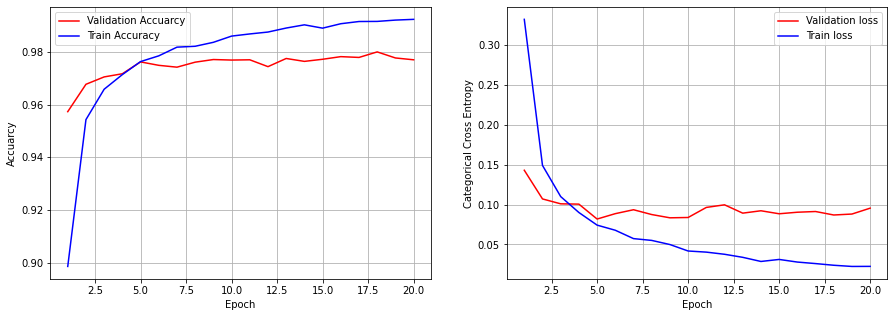

In [ ]:
# plot loss and accuracy
plot_graph(history)

Observations:

1. As compared to second model accuarcy not improved much 
2. validation loss decreased slightly 

So overall model with batch normalization and dropout layer gives better performance for MNIST dataset (model31)

### CIFAR Classifier

In [ ]:
# model without batch normalization gives a better accuarcy value compared to model in task 1
# built a model with a dropout layer and without batch normalisation layers
model32 = regularized_model(input_size = 32*32*3, n_classes=10, hidden_layers=4, n_nodes=256, learning_rate=0.0001, normalization=False)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 256)               786688    
                                                                 
 dense_24 (Dense)            (None, 256)               65792     
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 dense_26 (Dense)            (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 10)                2570      
                                                                 
Total params: 986,634
Trainable params: 986,634
Non-tr

In [ ]:
# train the model
history = model32.fit(x2_train,
                    y2_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(x2_val, y2_val)
                    )

Epoch 1/20
625/625 [==============================] - 4s 5ms/step - loss: 1.9207 - accuracy: 0.3037 - val_loss: 1.8172 - val_accuracy: 0.3482
Epoch 2/20
625/625 [==============================] - 3s 5ms/step - loss: 1.7177 - accuracy: 0.3868 - val_loss: 1.6949 - val_accuracy: 0.3933
Epoch 3/20
625/625 [==============================] - 3s 5ms/step - loss: 1.6280 - accuracy: 0.4197 - val_loss: 1.6233 - val_accuracy: 0.4208
Epoch 4/20
625/625 [==============================] - 3s 5ms/step - loss: 1.5758 - accuracy: 0.4419 - val_loss: 1.5699 - val_accuracy: 0.4389
Epoch 5/20
625/625 [==============================] - 3s 5ms/step - loss: 1.5256 - accuracy: 0.4575 - val_loss: 1.5475 - val_accuracy: 0.4557
Epoch 6/20
625/625 [==============================] - 3s 5ms/step - loss: 1.4896 - accuracy: 0.4700 - val_loss: 1.5164 - val_accuracy: 0.4608
Epoch 7/20
625/625 [==============================] - 4s 6ms/step - loss: 1.4585 - accuracy: 0.4844 - val_loss: 1.5145 - val_accuracy: 0.4576
Epoch 

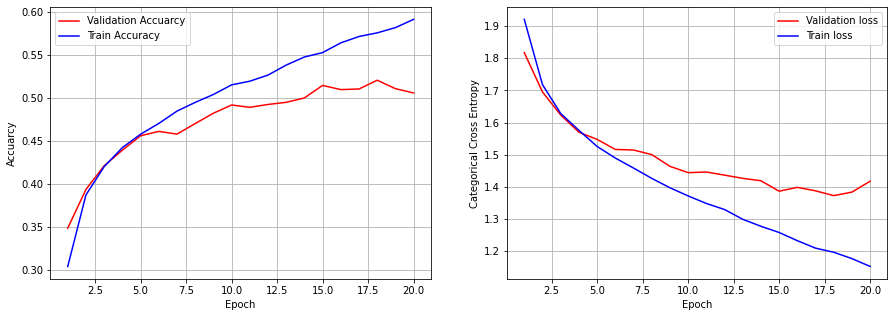

In [ ]:
# plot accuracy and loss 
plot_graph(history)

Observations:

1. No improvement in validation accuracy 
2. validation loss slightly increased

So best model for CIFAR-10 dataset is model without batchnormalization and dropout layers (model12)

### **Best Models**

### MNIST Classifier

Best Model:
1. No.of hidden layers =2
2. No.of nodes in hidden layers = 80
3. Learning rate =  0.001
4. Batch Normalization after each hidden layers
5. Dropout layer before output layer

In [ ]:
# model31 is best model
model31.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 90)                70650     
                                                                 
 batch_normalization_7 (Batc  (None, 90)               360       
 hNormalization)                                                 
                                                                 
 dense_20 (Dense)            (None, 90)                8190      
                                                                 
 batch_normalization_8 (Batc  (None, 90)               360       
 hNormalization)                                                 
                                                                 
 dense_21 (Dense)            (None, 90)                8190      
                                                                 
 batch_normalization_9 (Batc  (None, 90)              

In [ ]:
print("Evaluate on test data")
results = model31.evaluate(x1_test, y1_test, batch_size=64)
print("\nEvaluation Results:\n-------------------")
print(pd.DataFrame(results, columns = [' '], index=['Test Loss','Test Accuracy']))

Evaluate on test data
157/157 [==============================] - 1s 3ms/step - loss: 0.0840 - accuracy: 0.9810

Evaluation Results:
-------------------
                       
Test Loss      0.084007
Test Accuracy  0.981000


### CIFAR Classifier

Best Model:
1. No.of hidden layers = 4
2. No.of nodes in hidden layers = 192
3. Learning rate =  0.0001
4. No Batch Normalization after each hidden layers
5. No Dropout layer before output layer

In [ ]:
# model12 is best model

model12.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               786688    
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                                 
Total params: 986,634
Trainable params: 986,634
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("Evaluate on test data")
results = model12.evaluate(x2_test, y2_test, batch_size=64)
print("\nEvaluation Results:\n-------------------")
print(pd.DataFrame(results, columns = [' '], index=['Test Loss','Test Accuracy']))

Evaluate on test data
157/157 [==============================] - 1s 3ms/step - loss: 1.3441 - accuracy: 0.5315

Evaluation Results:
-------------------
                       
Test Loss      1.344133
Test Accuracy  0.531500
